#SVC

##Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import resample
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

#!pip install pandas openpyxl xlrd


##Load Data

In [2]:
df=pd.read_excel("/content/default of credit card clients.xls",header=1)

In [3]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df.rename(columns={'default payment next month' : 'IsDefaulter'}, inplace=True)
df.rename(columns={'PAY_0':'PAY_SEPT','PAY_2':'PAY_AUG','PAY_3':'PAY_JUL','PAY_4':'PAY_JUN','PAY_5':'PAY_MAY','PAY_6':'PAY_APR'},inplace=True)
df.rename(columns={'BILL_AMT1':'BILL_AMT_SEPT','BILL_AMT2':'BILL_AMT_AUG','BILL_AMT3':'BILL_AMT_JUL','BILL_AMT4':'BILL_AMT_JUN','BILL_AMT5':'BILL_AMT_MAY','BILL_AMT6':'BILL_AMT_APR'}, inplace = True)
df.rename(columns={'PAY_AMT1':'PAY_AMT_SEPT','PAY_AMT2':'PAY_AMT_AUG','PAY_AMT3':'PAY_AMT_JUL','PAY_AMT4':'PAY_AMT_JUN','PAY_AMT5':'PAY_AMT_MAY','PAY_AMT6':'PAY_AMT_APR'},inplace=True)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,...,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,PAY_AMT_SEPT,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR,IsDefaulter
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


##Missing Data Check and Preprocess

In [5]:
df.dtypes

,0
ID,int64
LIMIT_BAL,int64
SEX,int64
EDUCATION,int64
MARRIAGE,int64
AGE,int64
PAY_SEPT,int64
PAY_AUG,int64
PAY_JUL,int64
PAY_JUN,int64


In [6]:
df['SEX'].unique()

array([2, 1])

In [7]:
df['EDUCATION'].unique() #contains extra categories

array([2, 1, 3, 5, 4, 6, 0])

In [8]:
df['MARRIAGE'].unique() #contains 0. could be missing data(for the simplicity of the problem we shall assume this)

array([1, 2, 3, 0])

In [9]:
#replacing values with labels

df.replace({'SEX': {1 : 'Male', 2 : 'Female'}}, inplace=True)
df.replace({'EDUCATION' : {1 : 'Graduate School', 2 : 'University', 3 : 'High School', 4 : 'Others'}}, inplace=True)
df.replace({'MARRIAGE' : {1 : 'Married', 2 : 'Single', 3 : 'Others'}}, inplace = True)
df.replace({'IsDefaulter' : {1 : 'Yes', 0 : 'No'}}, inplace = True)

In [10]:
fil = (df['EDUCATION'] == 0) | (df['EDUCATION'] == 5) | (df['EDUCATION'] == 6) | (df['EDUCATION'] == 4)
df.loc[fil, 'EDUCATION'] = 'Others'

#Value counts for marriage category
fil = df['MARRIAGE']==0
df.loc[fil,'MARRIAGE'] = 'Others'

In [11]:
#Label encoding
encode_num = {"SEX":{"Female":0,"Male":1}, "IsDefaulter":{"Yes":1,"No":0}}
df=df.replace(encode_num)

In [12]:
#creating dummy variables
df = pd.get_dummies(df, columns=['EDUCATION','MARRIAGE'],drop_first=True)
df = pd.get_dummies(df, columns=['PAY_SEPT', 'PAY_AUG', 'PAY_JUL', 'PAY_JUN', 'PAY_MAY', 'PAY_APR'], drop_first = True )

In [13]:
df.drop('ID',axis=1,inplace=True)

##Oversample Data and Split

In [14]:
#importing SMOTE to handle class imbalance
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(df[(i for i in list(df.describe(include='all').columns) if i != 'IsDefaulter')], df['IsDefaulter'])

print('Original unbalanced dataset shape', len(df))
print('Resampled balanced dataset shape', len(y_smote))

Original unbalanced dataset shape 30000
Resampled balanced dataset shape 46728


In [15]:
#creating new dataframe from balanced dataset after SMOTE

balanced_df = pd.DataFrame(x_smote, columns=list(i for i in list(df.describe(include='all').columns) if i != 'IsDefaulter'))

In [16]:
balanced_df.head()

,LIMIT_BAL,SEX,AGE,BILL_AMT_SEPT,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,PAY_AMT_SEPT,...,PAY_MAY_8,PAY_APR_-1,PAY_APR_0,PAY_APR_2,PAY_APR_3,PAY_APR_4,PAY_APR_5,PAY_APR_6,PAY_APR_7,PAY_APR_8
0,20000,0,24,3913,3102,689,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,120000,0,26,2682,1725,2682,3272,3455,3261,0,...,False,False,False,True,False,False,False,False,False,False
2,90000,0,34,29239,14027,13559,14331,14948,15549,1518,...,False,False,True,False,False,False,False,False,False,False
3,50000,0,37,46990,48233,49291,28314,28959,29547,2000,...,False,False,True,False,False,False,False,False,False,False
4,50000,1,57,8617,5670,35835,20940,19146,19131,2000,...,False,False,True,False,False,False,False,False,False,False


In [17]:
#adding target variable to new created dataframe

balanced_df['IsDefaulter']=y_smote

In [18]:
#seperating dependant and independant variabales
X = balanced_df[(list(i for i in list(balanced_df.describe(include='all').columns) if i != 'IsDefaulter'))]
y = balanced_df['IsDefaulter']

In [19]:
#importing libraries for data transformation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [20]:
#importing libraries for splitting data into training and testing dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42, stratify=y)

##Build and test base SVC

In [21]:
svm=SVC(random_state=42)
svm.fit(X_train,y_train)

SVC(random_state=42)

The accuracy on test data is  0.818
The precision on test data is  0.76
The recall on test data is  0.859
The f1 on test data is  0.806
The roc on test data is  0.822


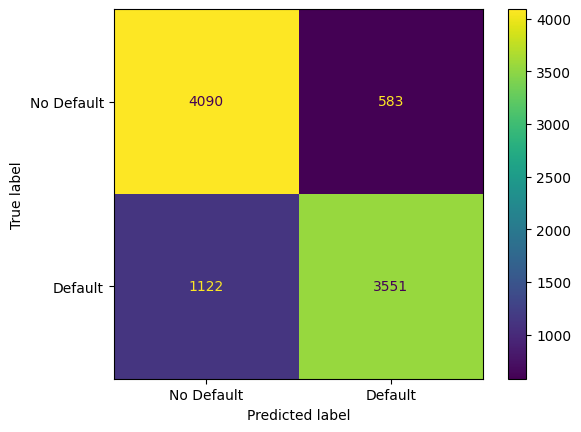

In [22]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc

y_pred_svm=svm.predict(X_test)

#getting all scores for Support Vector Machine
accuracy_svm = round(accuracy_score(y_pred_svm,y_test), 3)
precision_score_svm = round(precision_score(y_pred_svm,y_test), 3)
recall_score_svm = round(recall_score(y_pred_svm,y_test), 3)
f1_score_svm = round(f1_score(y_pred_svm,y_test), 3)
roc_score_svm = round(roc_auc_score(y_pred_svm,y_test), 3)

print("The accuracy on test data is ", accuracy_svm)
print("The precision on test data is ", precision_score_svm)
print("The recall on test data is ", recall_score_svm)
print("The f1 on test data is ", f1_score_svm)
print("The roc on test data is ", roc_score_svm)

ConfusionMatrixDisplay(confusion_matrix(y_test, svm.predict(X_test)),display_labels=['No Default','Default']).plot()

##Optimize using GridSearch

In [25]:
param_grid={'C':[0.5,1,10,100,1000],'gamma':[1,0.1,0.01,0.001,0.0001],'kernel':['rbf'],}

optimal_params=GridSearchCV(SVC(),param_grid,cv=5,verbose=0)
optimal_params.fit(X_train[:2000],y_train[:2000])
print(optimal_params.best_params_)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


In [26]:
svm_better=SVC(C=1,gamma=0.001,kernel='rbf',random_state=42)
svm_better.fit(X_train,y_train)

SVC(C=1, gamma=0.001, random_state=42)

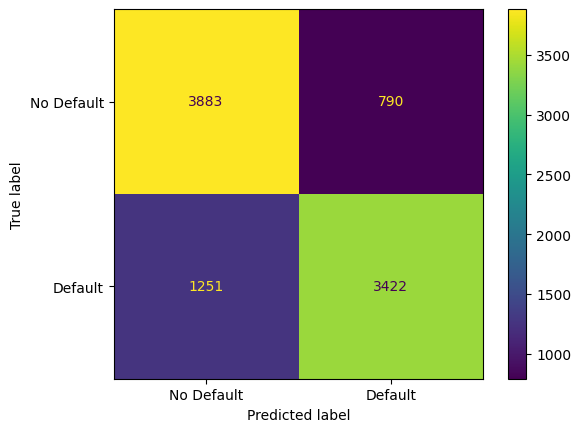

In [27]:
ConfusionMatrixDisplay(confusion_matrix(y_test, svm_better.predict(X_test)),display_labels=['No Default','Default']).plot()

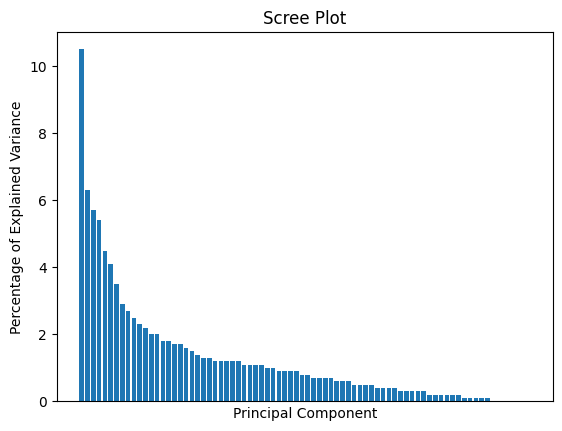

In [28]:
pac=PCA()
X_pca_train=pac.fit_transform(X_train)

per_var=np.round(pac.explained_variance_ratio_*100,decimals=1)
labels=['PC'+str(x) for x in range(1,len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1),height=per_var,tick_label=labels)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

#we need first two bars to be really high for PCA to make sense

#Decision Trees

The accuracy on test data is  0.789
The precision on test data is  0.773
The recall on test data is  0.799
The f1 on test data is  0.786
The roc on test data is  0.789


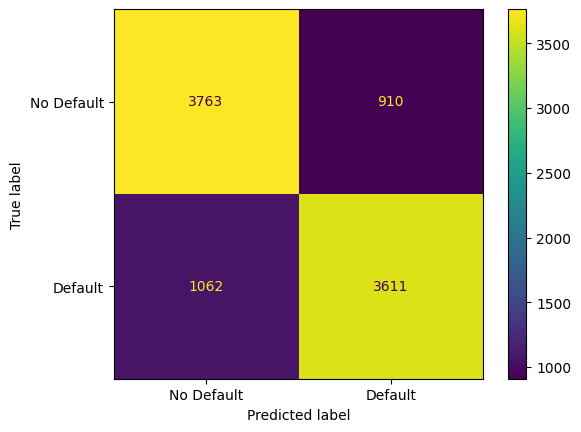

In [23]:
from sklearn.tree import DecisionTreeClassifier

class_tree=DecisionTreeClassifier(min_samples_split=30,min_samples_leaf=10,random_state=10)
class_tree.fit(X_train,y_train)

y_pred_dt=class_tree.predict(X_test)

#getting all scores for Decision Tree
accuracy_dt = round(accuracy_score(y_pred_dt,y_test), 3)
precision_score_dt = round(precision_score(y_pred_dt,y_test), 3)
recall_score_dt = round(recall_score(y_pred_dt,y_test), 3)
f1_score_dt = round(f1_score(y_pred_dt,y_test), 3)
roc_score_dt = round(roc_auc_score(y_pred_dt,y_test), 3)

print("The accuracy on test data is ", accuracy_dt)
print("The precision on test data is ", precision_score_dt)
print("The recall on test data is ", recall_score_dt)
print("The f1 on test data is ", f1_score_dt)
print("The roc on test data is ", roc_score_dt)

ConfusionMatrixDisplay(confusion_matrix(y_test, class_tree.predict(X_test)),display_labels=['No Default','Default']).plot()

#Random Forest Classifcation

The accuracy on test data is  0.862
The precision on test data is  0.833
The recall on test data is  0.885
The f1 on test data is  0.858
The roc on test data is  0.864


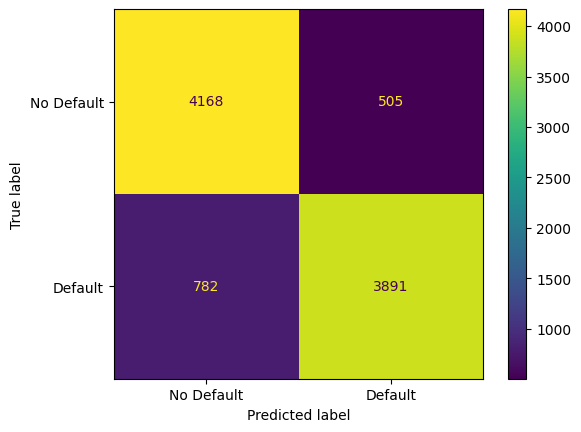

In [24]:
#importing Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier


#fitting data into Random Forest Classifier
rfc=RandomForestClassifier(n_estimators=50)
rfc.fit(X_train, y_train)

#class prediction of y
y_pred_rfc=rfc.predict(X_test)


#getting all scores for Random Forest Classifier
accuracy_rfc = round(accuracy_score(y_pred_rfc,y_test), 3)
precision_score_rfc = round(precision_score(y_pred_rfc,y_test), 3)
recall_score_rfc = round(recall_score(y_pred_rfc,y_test), 3)
f1_score_rfc = round(f1_score(y_pred_rfc,y_test), 3)
roc_score_rfc = round(roc_auc_score(y_pred_rfc,y_test), 3)

print("The accuracy on test data is ", accuracy_rfc)
print("The precision on test data is ", precision_score_rfc)
print("The recall on test data is ", recall_score_rfc)
print("The f1 on test data is ", f1_score_rfc)
print("The roc on test data is ", roc_score_rfc)



cm_rfc = confusion_matrix(y_test, y_pred_rfc )

ConfusionMatrixDisplay(cm_rfc,display_labels=['No Default','Default']).plot()
